### Устанавливаем нужные библиотеки

In [1]:
!pip install catboost optuna tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 1.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

import lightgbm as lgbm

import shap

### Feature Engineering

In [61]:
df = pd.read_csv("/content/final_data_agg.csv",sep = ";", index_col = 0)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0


In [62]:
df["id"] = range(len(df))
extracted_features = extract_features(df, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 3360/3360 [01:58<00:00, 28.47it/s]


In [63]:
impute(extracted_features)

The columns ['day_of_week__mean_abs_change' 'day_of_week__mean_change'
 'day_of_week__mean_second_derivative_central' ...
 'rain__permutation_entropy__dimension_7__tau_1'
 'rain__query_similarity_count__query_None__threshold_0.0'
 'rain__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.


,day_of_week__variance_larger_than_standard_deviation,day_of_week__has_duplicate_max,day_of_week__has_duplicate_min,day_of_week__has_duplicate,day_of_week__sum_values,day_of_week__abs_energy,day_of_week__mean_abs_change,day_of_week__mean_change,day_of_week__mean_second_derivative_central,day_of_week__median,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,5.0,25.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
extracted_features["id"] = range(len(df))

In [65]:
df = pd.merge(df, extracted_features, on='id')
df.drop("id", axis = 1, inplace = True)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__variance_larger_than_standard_deviation,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
df["revenue__benford_correlation"]

0     -0.297356
1      0.864123
2      0.864123
3      0.864123
4     -0.272809
         ...   
415    0.864123
416   -0.200946
417   -0.241690
418   -0.272809
419   -0.241690
Name: revenue__benford_correlation, Length: 420, dtype: float64

In [70]:
def drop_uninformative(data, threshold = 0.99):
  count = 0
  for column in data.columns:
    max_freq = data[column].value_counts(normalize=True).max()
    if max_freq >= threshold:
      data.drop(column, axis=1, inplace=True)
      count += 1

  print(f"{count} колонок удалено")


In [71]:
drop_uninformative(df)

6056 колонок удалено


In [72]:
for i in range(1, 8):
  df[i] = df["revenue"].shift(i)

df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__sum_values,...,rain__value_count__value_1,rain__range_count__max_1__min_-1,rain__count_below__t_0,1,2,3,4,5,6,7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,3.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,4.0,...,1.0,0.0,0.0,96630.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,5.0,...,0.0,1.0,1.0,108024.5,96630.0,NaN,NaN,NaN,NaN,NaN
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,6.0,...,0.0,1.0,1.0,122352.0,108024.5,96630.0,NaN,NaN,NaN,NaN
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,1.0,1.0,119441.7,122352.0,108024.5,96630.0,NaN,NaN,NaN


In [74]:
df.dropna(inplace = True)
df.shape

(413, 224)

In [75]:
df.reset_index(drop = True, inplace = True)

In [76]:
def remove_highly_correlated_features(df, threshold=0.8):
    # Вычисление матрицы корреляций, устанавливая numeric_only=True
    corr_matrix = df.corr(numeric_only=True).abs()

    # Выбор верхнего треугольника матрицы корреляций
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)
    )

    # Нахождение индексов колонок с корреляцией больше, чем threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold) and column != "revenue__benford_correlation"]

    # Удаление колонок
    df_reduced = df.drop(to_drop, axis=1)

    return df_reduced, to_drop

# Использование функции
df, dropped_features = remove_highly_correlated_features(df, threshold=0.7)
if dropped_features:
    print("Dropped columns:", dropped_features)
else:
    print("No columns were dropped.")


Dropped columns: ['day_of_week__sum_values', 'day_of_week__abs_energy', 'day_of_week__median', 'day_of_week__mean', 'day_of_week__root_mean_square', 'day_of_week__maximum', 'day_of_week__absolute_maximum', 'day_of_week__minimum', 'day_of_week__quantile__q_0.1', 'day_of_week__quantile__q_0.2', 'day_of_week__quantile__q_0.3', 'day_of_week__quantile__q_0.4', 'day_of_week__quantile__q_0.6', 'day_of_week__quantile__q_0.7', 'day_of_week__quantile__q_0.8', 'day_of_week__quantile__q_0.9', 'day_of_week__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'day_of_week__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'day_of_week__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'day_of_week__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'day_of_week__fft_coefficient__attr_"real"__coeff_0', 'day_of_week__fft_coefficient__attr_"abs"__coeff_0', 'day_of_week__value_count__value_1', 'day_of_week__range_count__max_1__min_-1', 'day_of_week__count_below__t_0', 'month__sum_

In [77]:
df["revenue__benford_correlation"]

0     -0.297356
1      0.864123
2      0.864123
3      0.864123
4     -0.272809
         ...   
408    0.864123
409   -0.200946
410   -0.241690
411   -0.272809
412   -0.241690
Name: revenue__benford_correlation, Length: 413, dtype: float64

In [78]:
df.shape

(413, 22)

In [79]:
df

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__benford_correlation,...,revenue__benford_correlation,avg_temp__benford_correlation,avg_temp__range_count__max_1__min_-1,1,2,3,4,5,6,7
0,2022-09-08,3,9,0,3,91541.00,9.2,0,1,0.062915,...,-0.297356,-0.297356,0.0,117891.75,104438.50,87863.50,119441.70,122352.00,108024.5,96630.0
1,2022-09-09,4,9,0,3,124681.88,10.2,0,0,-0.064614,...,0.864123,0.864123,0.0,91541.00,117891.75,104438.50,87863.50,119441.70,122352.0,108024.5
2,2022-09-10,5,9,0,3,130622.00,12.1,0,0,-0.145280,...,0.864123,0.864123,0.0,124681.88,91541.00,117891.75,104438.50,87863.50,119441.7,122352.0
3,2022-09-11,6,9,0,3,118543.00,13.0,0,0,-0.200946,...,0.864123,0.864123,0.0,130622.00,124681.88,91541.00,117891.75,104438.50,87863.5,119441.7
4,2022-09-12,0,9,0,3,88454.00,12.0,0,1,0.062915,...,-0.272809,0.864123,0.0,118543.00,130622.00,124681.88,91541.00,117891.75,104438.5,87863.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2023-10-22,6,10,0,3,138996.12,2.6,1,0,-0.200946,...,0.864123,0.295657,0.0,150704.60,106856.00,62522.00,75438.50,94493.00,83683.0,104129.5
409,2023-10-23,0,10,0,3,61260.00,4.4,0,1,0.062915,...,-0.200946,-0.064614,0.0,138996.12,150704.60,106856.00,62522.00,75438.50,94493.0,83683.0
410,2023-10-24,1,10,0,3,70993.00,1.4,0,1,0.864123,...,-0.241690,0.864123,0.0,61260.00,138996.12,150704.60,106856.00,62522.00,75438.5,94493.0
411,2023-10-25,2,10,0,3,85317.97,-0.3,0,0,0.295657,...,-0.272809,0.062915,1.0,70993.00,61260.00,138996.12,150704.60,106856.00,62522.0,75438.5


In [80]:
train_size = int(len(df) * 0.6)
test_size = int(len(df) * 0.2)
val_size = int(len(df) * 0.2)

train_index = list(range(0, train_size))
val_index = list(range(train_size, train_size + val_size))
test_index = list(range(train_size + val_size, len(df)))

train = df[:train_size]
val = df[train_size:]
test = df[train_size: ]

In [ ]:
train_size, test_size, val_size
train_index, val_index, test_index

In [83]:
X_train, y_train = df.loc[train_index].drop(["revenue", "time"], axis = 1), df.loc[train_index]["revenue"]
X_val, y_val = df.loc[val_index].drop(["revenue", "time"], axis = 1), df.loc[val_index]["revenue"]
X_test, y_test = df.loc[test_index].drop(["revenue", "time"], axis = 1), df.loc[test_index]["revenue"]

In [84]:
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

### Обучаем модельки

#### Обучаем CatBoost

In [85]:
catboost_model = CatBoostRegressor(verbose=0)
catboost_model.fit(X_train, y_train)
catboost_prediction = catboost_model.predict(X_val)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, catboost_prediction))}")
feature = pd.DataFrame()
feature["feature"] = X_train.columns
feature["importances"] = catboost_model.feature_importances_
feature.sort_values(by = "importances", ascending = False).reset_index(drop = True)

RMSE = 13216.436331488916


,feature,importances
0,revenue__benford_correlation,73.511023
1,6,3.102223
2,7,2.946700
3,5,2.492155
4,2,2.198191
5,season,2.133406
6,avg_temp,1.878308
7,day_of_week__benford_correlation,1.811031
8,3,1.788904
9,1,1.561290


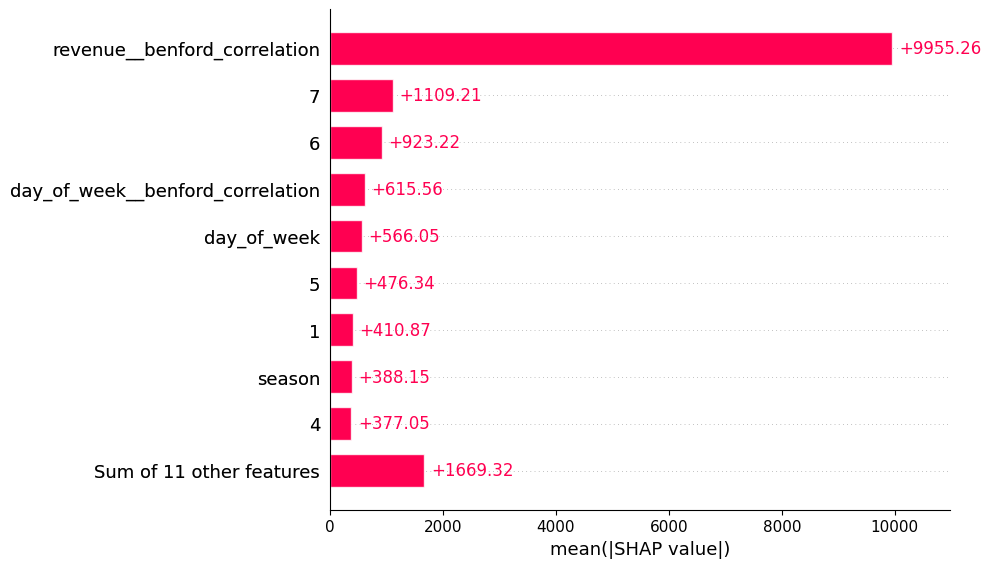

In [86]:
explainer = shap.Explainer(catboost_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

In [100]:
shap_sum = np.abs(shap_values.values).mean(axis=0)

# Создайте DataFrame для удобства сортировки и визуализации
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']

# Отсортируйте признаки по важности
feature_importance = feature_importance.sort_values(by='shap_importance', ascending=False)

# Выберите 20 самых важных признаков
top_20_features_catboost = feature_importance.head(20)

print(top_20_features_catboost)

                                 feature shap_importance
10          revenue__benford_correlation    12232.789972
19                                     7      773.276503
18                                     6      752.485266
14                                     2      646.773743
13                                     1      464.327731
17                                     5      414.958805
16                                     4      404.996042
4                               avg_temp      355.310326
0                            day_of_week      344.043779
15                                     3      328.052254
11         avg_temp__benford_correlation      141.940225
2                            salary_week      100.839556
3                                 season        52.98114
6                                   rain       40.958141
1                                  month       35.485082
5                                   snow       12.076341
7       day_of_week__benford_co

#### Обучаем LIghtGBM

In [93]:
train_data = lgbm.Dataset(X_train, label=y_train)
val_data = lgbm.Dataset(X_val, label=y_val, reference=train_data)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': 0
}

lgbm_model = lgbm.train(params, train_data, valid_sets = [val_data], callbacks=[lgbm.early_stopping(stopping_rounds=10)], num_boost_round=1000)
lgbm_prediction = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, lgbm_prediction))}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

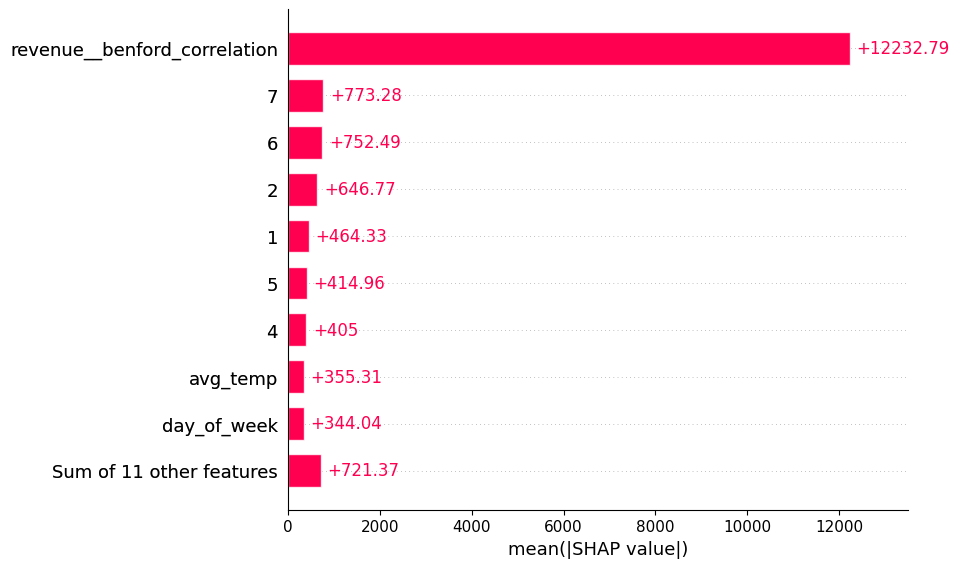

In [94]:
explainer = shap.Explainer(lgbm_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

In [98]:
shap_sum = np.abs(shap_values.values).mean(axis=0)

# Создайте DataFrame для удобства сортировки и визуализации
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']

# Отсортируйте признаки по важности
feature_importance = feature_importance.sort_values(by='shap_importance', ascending=False)

# Выберите 20 самых важных признаков
top_20_features_lgbm = feature_importance.head(20)

print(top_20_features_lgbm)

                                 feature shap_importance
10          revenue__benford_correlation    12232.789972
19                                     7      773.276503
18                                     6      752.485266
14                                     2      646.773743
13                                     1      464.327731
17                                     5      414.958805
16                                     4      404.996042
4                               avg_temp      355.310326
0                            day_of_week      344.043779
15                                     3      328.052254
11         avg_temp__benford_correlation      141.940225
2                            salary_week      100.839556
3                                 season        52.98114
6                                   rain       40.958141
1                                  month       35.485082
5                                   snow       12.076341
7       day_of_week__benford_co

#### Обучаем RandomForest

In [90]:
randforest_model = RandomForestRegressor(max_depth = 6, n_estimators=100, bootstrap=True)
randforest_model.fit(X_train, y_train)
randforest_prediction = randforest_model.predict(X_val)
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, randforest_prediction))}")

RMSE = 12402.77626268637


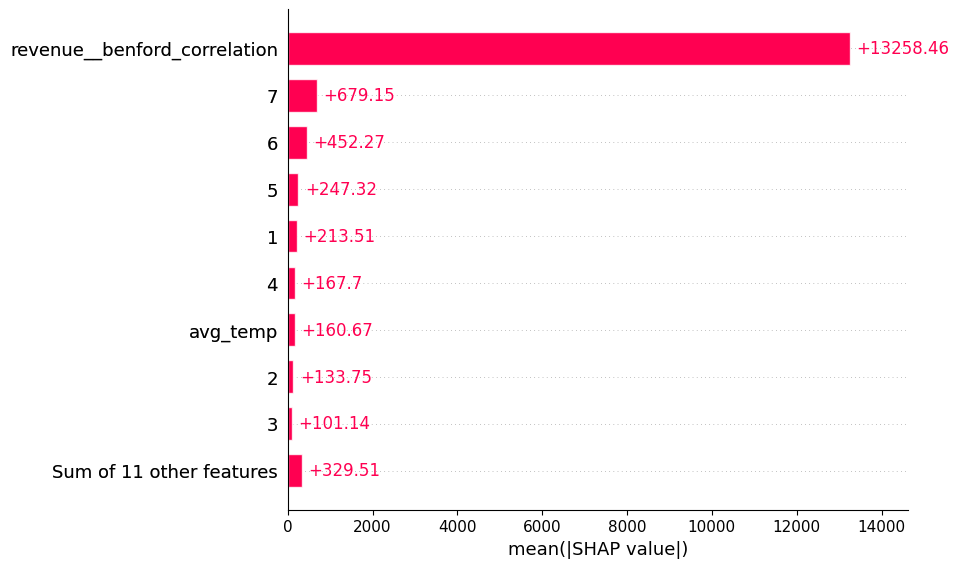

In [91]:
explainer = shap.Explainer(randforest_model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

#### Отбираем важные фичи

In [99]:
shap_sum = np.abs(shap_values.values).mean(axis=0)

# Создайте DataFrame для удобства сортировки и визуализации
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']

# Отсортируйте признаки по важности
feature_importance = feature_importance.sort_values(by='shap_importance', ascending=False)

# Выберите 20 самых важных признаков
top_20_features_randf = feature_importance.head(20)

print(top_20_features_randf)

                                 feature shap_importance
10          revenue__benford_correlation    12232.789972
19                                     7      773.276503
18                                     6      752.485266
14                                     2      646.773743
13                                     1      464.327731
17                                     5      414.958805
16                                     4      404.996042
4                               avg_temp      355.310326
0                            day_of_week      344.043779
15                                     3      328.052254
11         avg_temp__benford_correlation      141.940225
2                            salary_week      100.839556
3                                 season        52.98114
6                                   rain       40.958141
1                                  month       35.485082
5                                   snow       12.076341
7       day_of_week__benford_co

In [110]:
list(top_20_features_catboost["feature"][top_20_features_catboost["shap_importance"] > 10].values)

['revenue__benford_correlation',
 '7',
 '6',
 '2',
 '1',
 '5',
 '4',
 'avg_temp',
 'day_of_week',
 '3',
 'avg_temp__benford_correlation',
 'salary_week',
 'season',
 'rain',
 'month',
 'snow']

In [111]:
def select_high_shap_features(df1, df2, df3):

    feature_union = set()
    for df in [df1, df2, df3]:
      feat = list(df["feature"][df["shap_importance"] > 10].values)
      feature_union.update(feat)
    return feature_union

best_feature = select_high_shap_features(top_20_features_catboost, top_20_features_lgbm, top_20_features_randf)
best_feature

{'1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'avg_temp',
 'avg_temp__benford_correlation',
 'day_of_week',
 'month',
 'rain',
 'revenue__benford_correlation',
 'salary_week',
 'season',
 'snow'}

#### Обучаем и тюним финальную модель

In [112]:
def metric(y_pred, y_test):
  #print(f"======= Резултаты {model_name} =======")
  print()
  print("RMSE = ", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
  print("MAE = ", round(mean_absolute_error(y_test, y_pred),3))
  print("MAPE = ", round(mean_absolute_percentage_error(y_test, y_pred),3))
  print()

In [ ]:
model = CatBoostRegressor()
model.fit(X_train[best_feature], y_train)

In [114]:
metric(model.predict(X_val[best_feature]), y_val)


RMSE =  13255.106
MAE =  6209.857
MAPE =  0.062



Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [123]:
def objective(trial):
    # Определение диапазона гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'loss_function': 'RMSE',
    }

    # Создание и обучение модели
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train[best_feature], y_train, eval_set=[(X_val[best_feature], y_val)], early_stopping_rounds=100, verbose=0)

    # Предсказание и вычисление MSE
    preds = model.predict(X_val[best_feature])
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    return rmse

# Создание Optuna study и запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-02-04 10:17:22,661] A new study created in memory with name: no-name-474d8704-f8ab-42a9-85b1-515eb41e9b84
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
[I 2024-02-04 10:17:23,205] Trial 0 finished with value: 1

In [125]:
print("Лучший скор: ",study.best_value)
print('Лучшие параметры:', study.best_params)

Лучший скор:  12428.208255311993
Лучшие параметры: {'iterations': 52, 'depth': 4, 'learning_rate': 0.13033888553396786, 'random_strength': 0, 'bagging_temperature': 0.8799538626645118, 'l2_leaf_reg': 0.018693748326180024}


In [126]:
params = study.best_params
model = CatBoostRegressor(**params)
model.fit(X_train[best_feature], y_train, verbose = 0)
metric(model.predict(X_val[best_feature]), y_val)


RMSE =  12446.462
MAE =  5678.005
MAPE =  0.055



Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


### Финальная оценка модели

In [127]:
metric(model.predict(X_test[best_feature]), y_test)


RMSE =  7217.913
MAE =  4564.105
MAPE =  0.046



Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


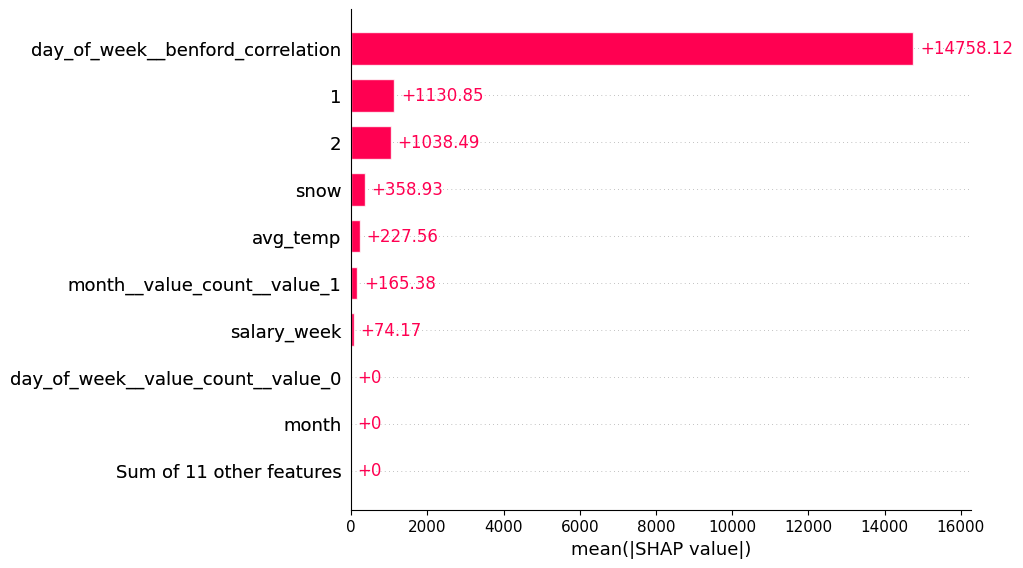

In [128]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))

In [129]:
pred_plot = pd.DataFrame(model.predict(X_test[best_feature]), index = list(range(329, 413)))

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


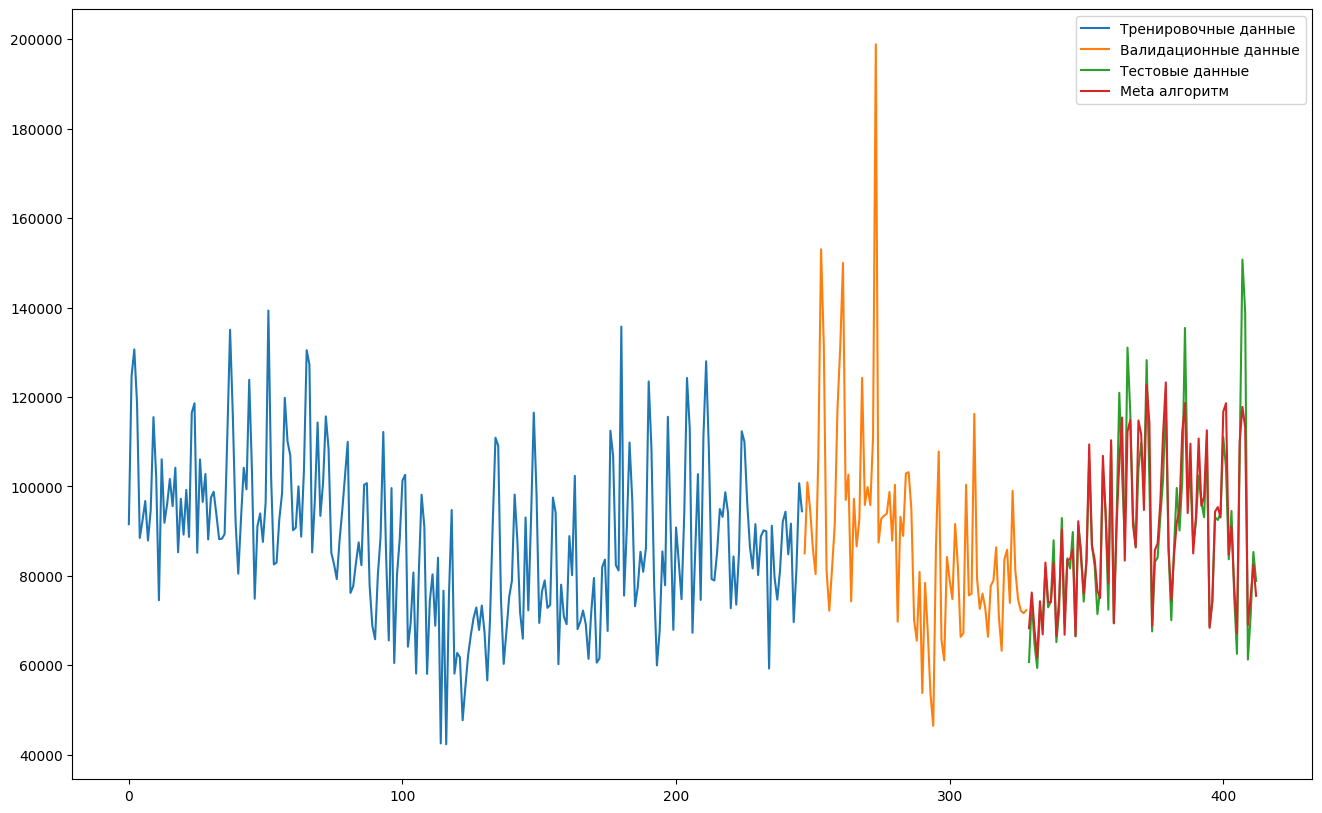

In [130]:
plt.figure(figsize = (16, 10))
plt.plot(y_train, label = "Тренировочные данные")
plt.plot(y_val, label = "Валидационные данные")
plt.plot(y_test, label = "Тестовые данные")
plt.plot(pred_plot, label = "Meta алгоритм")
plt.legend()
plt.show()